In [17]:
##ALL OF THE IMPORTS AND SUCH

from LightPipes import *
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import math
from numpy import genfromtxt
import colorcet as cc
import random
import aotools

import numpy as np
import scipy as sp

# plt.style.use('dark_background')
plt.style.use('default')

In [18]:
#Generate Colormap Intensity
cmap = np.zeros([256, 4])
cmap[:, 3] = np.linspace(0, 1, 256)
cmap[:, 0]= np.linspace(0, 0, 256)
cmap[:, 1]= np.linspace(0, 0, 256)
cmap[:, 2]= np.linspace(0, 0, 256)
#Intensity colours
imap = matplotlib.colors.ListedColormap(cmap)
#Phase colours
pmap= cc.m_CET_C6

Text(0, 0.5, 'Phase')

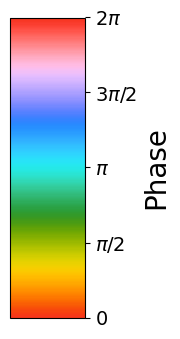

In [19]:
# Generate Phase colormap
import pylab as pl
import numpy as np

a = np.array([[0,1]])*2*np.pi
pl.figure(figsize=(3, 3))
img = pl.imshow(a, cmap=pmap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.1, 0.25, 1])
# pl.colorbar(orientation="horizontal", cax=cax, ticks=[])
cbar = pl.colorbar(orientation='vertical', cax=cax, ticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
cbar.ax.tick_params(labelsize=14)

plt.ylabel('Phase', fontsize=20)
# pl.savefig("colorbar.png")
# pl.savefig('colorbar.svg', format='svg', bbox_inches='tight')

In [20]:
##These are custom functions for plotting the LightPipes beams with Phase and Intensity on the same plot, alternatively just the Intensity or just the Phase.

def plotbeam(F):
    I=1-Intensity(0,F)
    Phi=np.mod(Phase(F),2*pi)

    ##aperature = plt.Circle((N/2-1, N/2), 30*cm*N/(2*size), color='w', fill=False)
    fig=plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(121)
    ax1.imshow(Phi,cmap=pmap,vmin=0,vmax=2*pi,interpolation='None')
    ax1.imshow(I,cmap=imap,vmin=np.min(I),vmax=np.max(I))
    ##ax1.add_patch(aperature)
        
    plt.axis('off')
    plt.tight_layout()

In [21]:
#This is a function for making OAM beams, 

def OAM(state: int=0 ,phase=0):
    
    F=Begin(size,wavelength,N)

    if(state==0):
        F=GaussBeam(F, w0)
    else:
        F=GaussBeam(F, w0, doughnut=True, n=0,m=state)

    return F

In [22]:
# Setting constant values

pi = sp.constants.pi
c = sp.constants.speed_of_light

# Beam/lightpipes settings
# wavelength = 785*nm # our wavelength
wavelength = 1e-6 # example wavelength from textbook
size = 30*cm # Size of window generated
w0 = 3*cm # Beam waist (radius)
# z = 5400 # Propagation distance (ours)
z = 50e3 # textbook example
N = 256 # Resolution
n = 2 # How many chunks we are dividing our distance into. ie how many phase screens

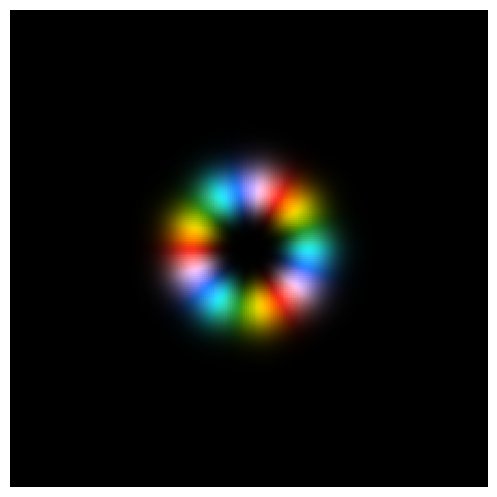

In [25]:
# Deterministic values

# C^2_n parameter. dependent on strength of turbulence
# we can always add more turbulence levels... maybe can set a distribution of some sorts?
C2_n = {
    'WeakerTurb' : 1e-18,
    'WeakTurb' : 1e-17,
    'MidWeakTurb' : 1e-16,
    'MidTurb' : 1e-15,
    'StrongTurb' : 1e-13 
}

# set turbulence strength
turb_strength = 'MidWeakTurb'

# determine fried parameter for the ith layer (i.e. for a specific distance chunk) this is r0_i
# this is also r0 PW according to matlab code 9.5, except we divide z/n (?)
# r0_i = pow(0.423*pow(2*pi/wavelength,2)*z/n*C2_n[turb_strength],-3/5)
# print(r0_i)

# r0 SW according to matlab code 9.5
r0_sw = pow(0.423*pow(2*pi/wavelength,2)*z*3/8*C2_n[turb_strength],-3/5)

# assuming all layers have the same turbulence strength
# r0 = pow(r0_i*n,-3/5) # would be used if we have one big block i think?

# scintillation index (sigma^2_chi) now
# scint = 1.33*pow(2*pi/wavelength,-5/6)*pow(z/n,5/6)
# scint = scint * n * pow(r0_i,-5/3) # this part assumes that all r0_i are equal to each other, 
# and that we are at the start of the slab of turblences such that z_i/(delta_z)=0

# wait new version of scintillation index
scint2 = 1.33 * pow(2*pi/wavelength,-5/6) * pow(z,5/6)
scint_sum = 0
for i in range(n):
    # print(1-((z/n)*(i))/z)
    scint_sum = scint_sum + pow(r0_i,-5/3) * pow(1-((z/n)*(i))/z, 5/6)
    
scint2 = scint2 * scint_sum

# for 9.75 probably better to leave for later... until we can confirm the other equations.

# setting our beam as simple gaussian or oam with l dim
F = OAM(3)
plotbeam(F)
# plt.savefig('oam3_beam_init.svg', format='svg')

initial_phase = Phase(F)

1.3442383934132118
1.4431248961229697


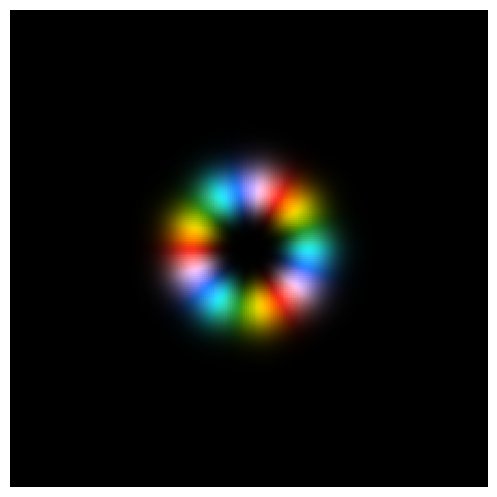

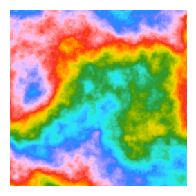

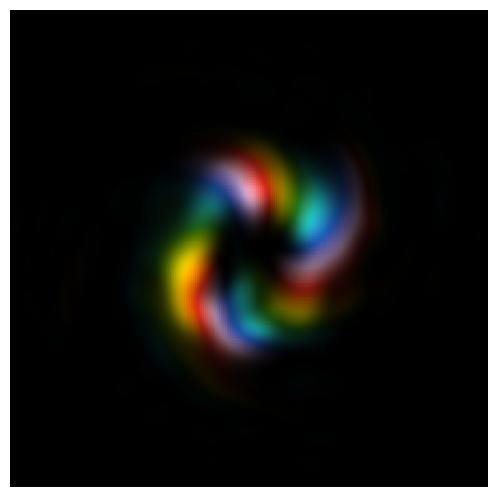

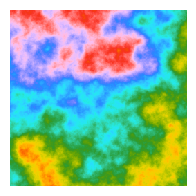

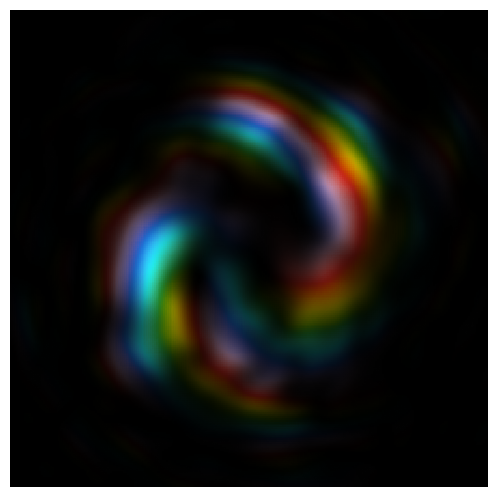

In [16]:
# propagating now
plotbeam(F)
for i in range(n):
    phase=aotools.turbulence.phasescreen.ft_sh_phase_screen(r0_i,N,size/N,100,1*mm)

    fig=plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(121)
    ax1.imshow(np.mod(phase+np.min(phase),2*pi),cmap=pmap,vmin=0,vmax=2*pi,interpolation='None')
    ##ax1.add_patch(aperature)
        
    plt.axis('off')
    # plt.savefig('phase_screen_C_n_1e_13.svg', format='svg')

    print(np.max(Intensity(F)))
    F=SubPhase(F,Phase(F)+phase)
    F=Fresnel(F,z/n)

    plotbeam(F)

final_phase = Phase(F)
# plt.savefig('oam3_beam_1e15.svg')